In [333]:
import os
import glob
import cv2
import numpy as np
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import cross_val_score
from scipy.ndimage.measurements import label
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Load Training Data

The vehicle data can be downloaded <a href = "https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip">here</a> and the non vehicle data can be downloaded <a href = https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip>here</a>.

In [2]:
files = []
y = []
base_dir = "../data/"
class_dir = ['vehicles','non-vehicles']

for i in range(len(class_dir)):
    #Data is seperated into folders where it was collected from
    folders = os.listdir(base_dir+class_dir[i])
    
    class_data = []
    for folder in folders:
        #Add Filenames to Class Data
        class_data.extend(glob.glob(base_dir+class_dir[i]+'/'+folder+'/*'))
        
    files.append(class_data)
    print(len(class_data), class_dir[i], "images")
    
    for j in range(len(class_data)):
        y.append(1-i)
    

8792 vehicles images
8968 non-vehicles images


## Preview Training Data

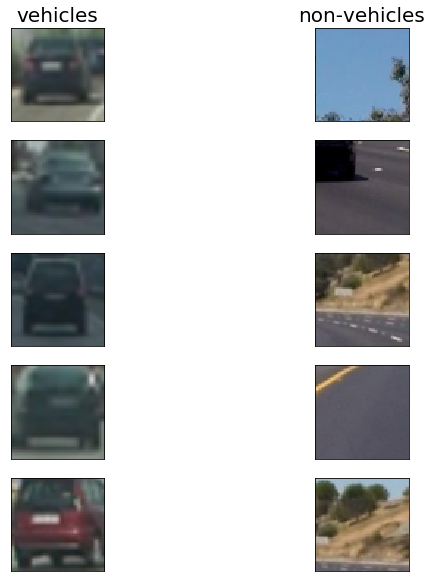

In [47]:
def load_preview_images(num_examples = 5,num_skip = 20):
    preview_images = []
    
    for i in range(len(class_dir)):
        class_preview = []
        for j in range(num_examples):
            img = cv2.cvtColor(cv2.imread(files[i][j*num_skip]),cv2.COLOR_BGR2RGB)
            class_preview.append(img)
                               
        preview_images.append(class_preview)
                               
    return preview_images
    
                               
def grid_plot(images, titles, col_type = None, ticks = False, figsize = (10,10),title_size = 20):
    fig, axs = plt.subplots(len(images[0]),len(images),figsize = figsize)
        
    for i in range(len(images)):
        
        #Set Column Title
        axs[0][i].set_title(titles[i],fontsize = title_size)

        for j in range(len(images[0])):
            if col_type is None or col_type[i] == 'img':
                if not ticks:
                    axs[j][i].tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
                #Map Image to plt
                axs[j][i].imshow(images[i][j])
            elif col_type[i] == 'hist':
                #base_img = i//4*4+1
                bin_edges = images[i][j][1]
                bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
                axs[j][i].bar(bin_centers,images[i][j][0])
                
            elif col_type[i] == '3d':
                base_img = i//4
                axs[j][i].tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
                axs[j][i]=fig.add_subplot(len(images[0]),len(images),j*len(images)+i+1,projection='3d')

                plot3d(images[i][j],images[base_img][j]/255,axs[j][i],axis_labels = list(titles[i]))
                
                
    
    #fig.tight_layout()    
    plt.show()
        
def plot_two_images(im1,im2,title1,title2):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9)) 
    ax1.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax1.imshow(im1)
    ax1.set_title(title1,fontsize=50)
    
    ax2.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax2.imshow(im2)
    ax2.set_title(title2,fontsize=50)
    
    plt.show()

            
preview_images = load_preview_images()
grid_plot(preview_images,class_dir)
                
            

## Histogram of Oriented Gradients Using Scikit-Learn

One way to gain information about the presence or lack of a vehicle in an image would be to look for the shape of a vehicle within an image. Previously this has been done using a Histogram of Gradients (HOG). The idea is to split the image up into small cells, and calculate the gradient of each cell, then pass the localized gradients to a classifier. HOGs have been used to detect pedestrians, so it makes sense to apply it to vehicle detection.

The histogram is created with 9 "bins" for all 360 degrees. This allows for a model using a HOG to have a high tolerance for variance when it comes to the shape of the car. That is important as it is means the model is already more likely to generalize and not overfit.  

In this project I will be passing the HOG feature to an SVM. This approach is different from a convolutional neural net. Since there is no version of "shared weights" in an SVM, the network will not be lociation invariant. In other words if this network was trained on cars apperaing in the top left of an image, it would not necessarily be able to recoginize a car in the bottom right. This problem is "solved" by having the vehicles nearly centered in the training and test data. 



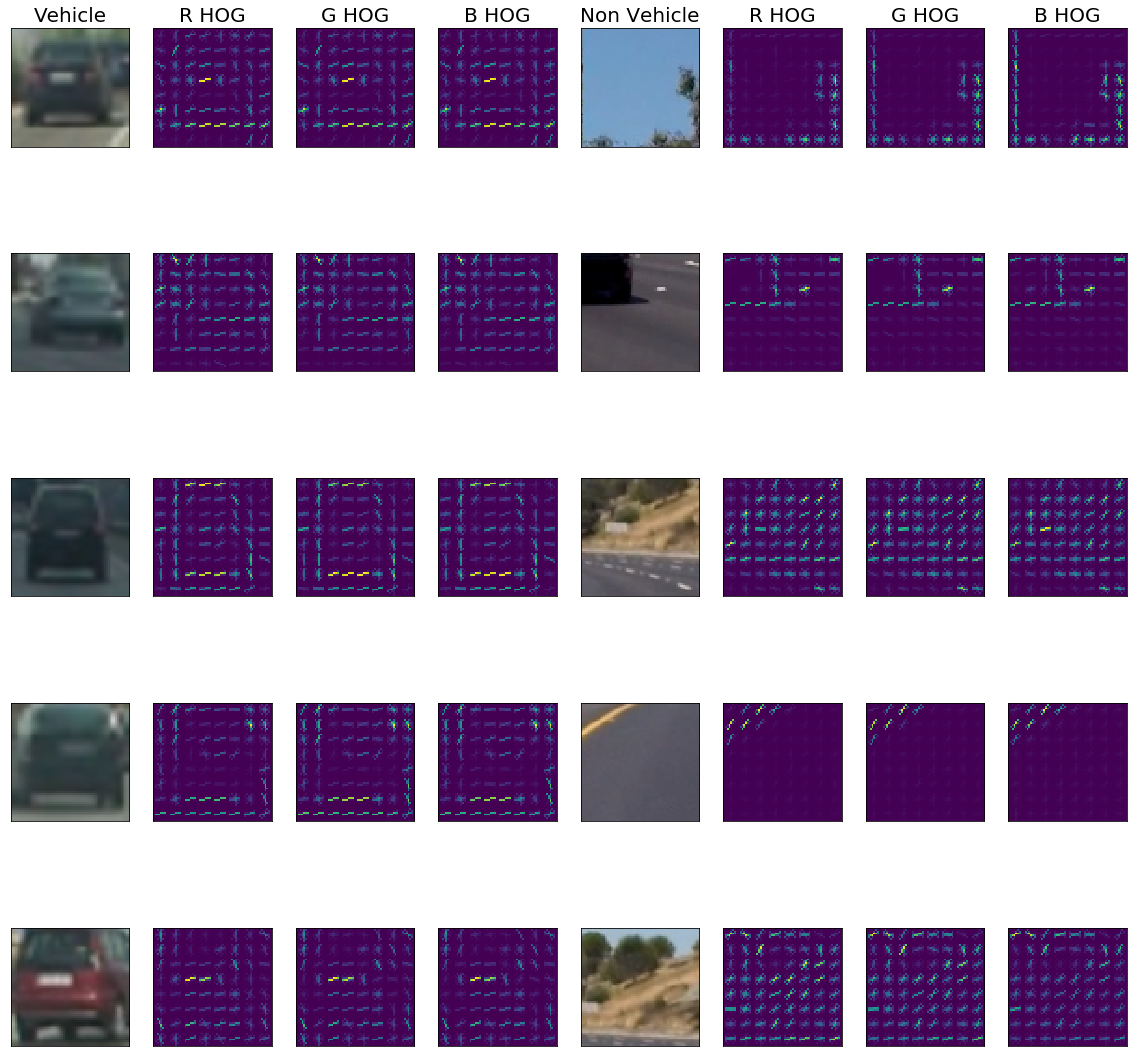

In [4]:
def get_hog_features(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_b7*7lock, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
    
def visualize_hog(preview_images):
    image_grid = []

    for i in range(len(preview_images)):
        image_grid.append(preview_images[i])
        
        for j in range(3):
            hog_images = []
            for k in range(len(preview_images[i])):
                _,hog_image = get_hog_features(preview_images[i][k][:,:,j],vis = True, feature_vec = True)
                hog_images.append(hog_image)
            image_grid.append(hog_images)
        
    titles = ['Vehicle','R HOG','G HOG','B HOG','Non Vehicle','R HOG','G HOG','B HOG']
    grid_plot(image_grid,titles,figsize = (20,20))
   

visualize_hog(preview_images)

## Histogram of Colors (RGB)

Another way to gain information from an image is with a Histogram of Colors. The idea is that while it's possible  a car will be camoflauged to have the same color tally as distant hill, it's unlikely and therefore we can gain information by assuming it isnt. This feature certianlly isn't enough to detect a car on it's own, but it absolutely can give information.

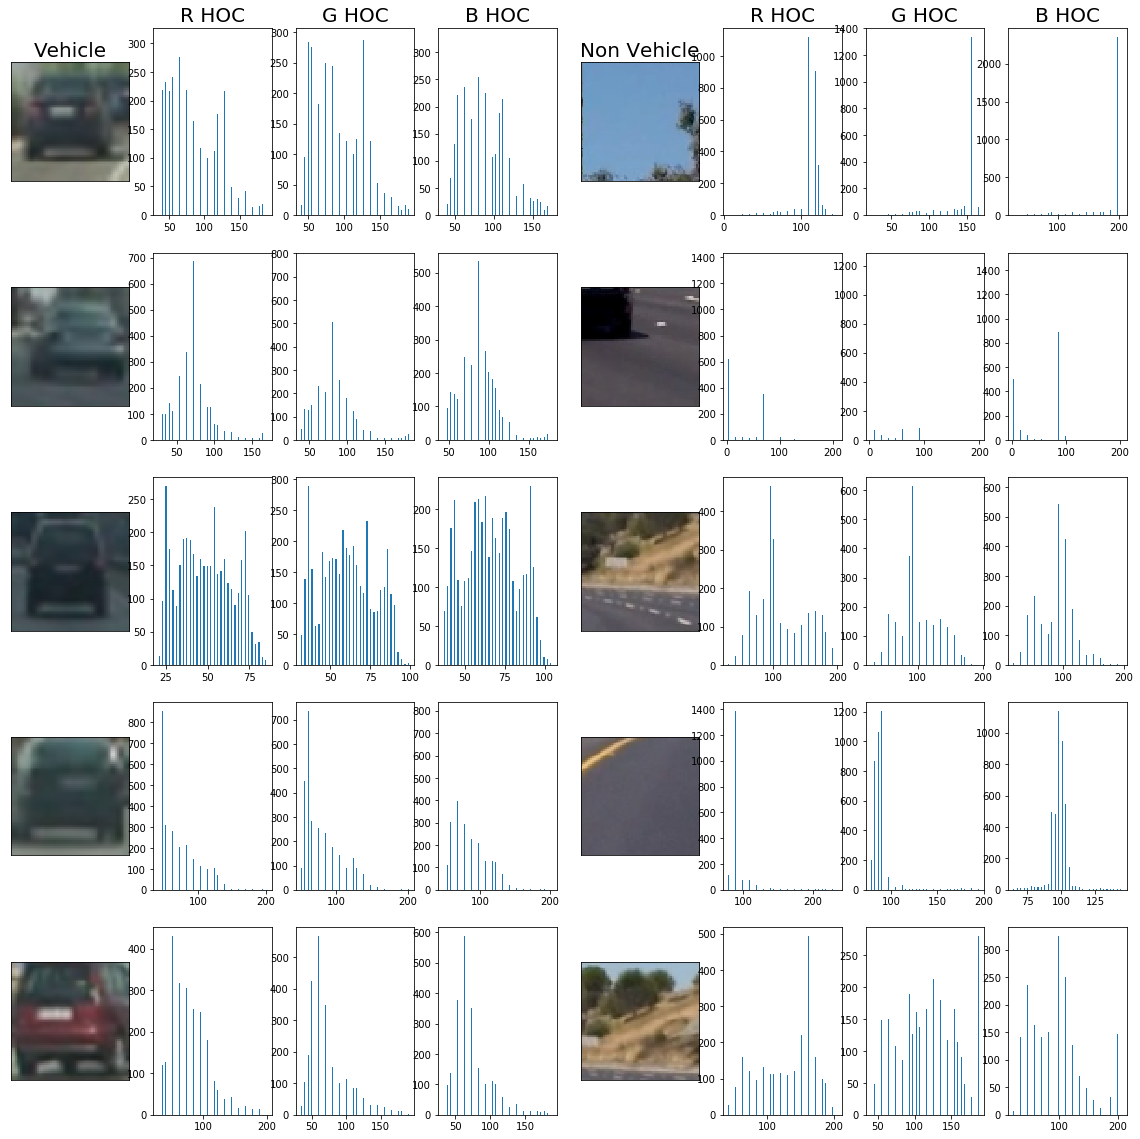

In [5]:
def color_hist(img, nbins=32):
    # Compute the histogram of the RGB channels separately
    c1hist = np.histogram(img[:,:,0], bins=nbins)
    c2hist = np.histogram(img[:,:,1], bins=nbins)
    c3hist = np.histogram(img[:,:,2], bins=nbins)

    # Generating bin centers
    bin_edges = c1hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((c1hist[0], c2hist[0], c3hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return c1hist, c2hist, c3hist, bin_centers, hist_features

def visualize_hoc(preview_images):
    image_grid = []

    for i in range(len(preview_images)):
        image_grid.append(preview_images[i])
        rgb_data = [[] for j in range(3)]
        for k in range(len(preview_images[i])):
            *rgb , bins, features = color_hist(preview_images[i][k])
            for j in range(3):
                rgb_data[j].append(rgb[j])
                
            
        for j in range(3):
            image_grid.append(rgb_data[j])
        
    titles = ['Vehicle','R HOC','G HOC','B HOC','Non Vehicle','R HOC','G HOC','B HOC']
    col_type = ['img','hist','hist','hist','img','hist','hist','hist']
    grid_plot(image_grid,titles,col_type,figsize = (20,20))
    
    
visualize_hoc(preview_images)

## Comparing Color Spaces for Vehicle Detection

While there is some corelation between a Histogram of Colors and the images' class, using an RGB HOC isn't the best choice to help the model generalize. This is because in RGB colorspace, each color channel is required to give information about color and intensity. Where as other color channels seperate the color and intensity, which would allow a model to learn a less unique, and more general, idea about what makes up a car.

Below I'm comparing the vehicle images to random non vehicle images by plotting different color spaces in three dimensions, and while there is significant variance between vehicles, there is a clear corelation between colors in an image and the class of an image. The charts below certianlly aren't scientific, but they are still good for getting an intuition on what color space could help differentiate vehicles and non vehicles.

When looking at the charts, the points on the vehicle side tend to be more clustered around each other. This makes sense to me because a car tend to be the same color all over, and they're convex so they have minimal shadows, and therefore minimal color variations. Therefore any changes in color would be gradual. Maybe more importantly, an image centered on a car is focused on one close object, where as an image focused on a distant hill will likely have multiple objects of different colors. This means I can expect to find that images of cars have less variance in all color spaces.

After looking at the charts, I have a gut feeling that the HLS and YCrCb color spaces have the best ability to differentiate vehicles and non vehicles, especially in comparison to RGB

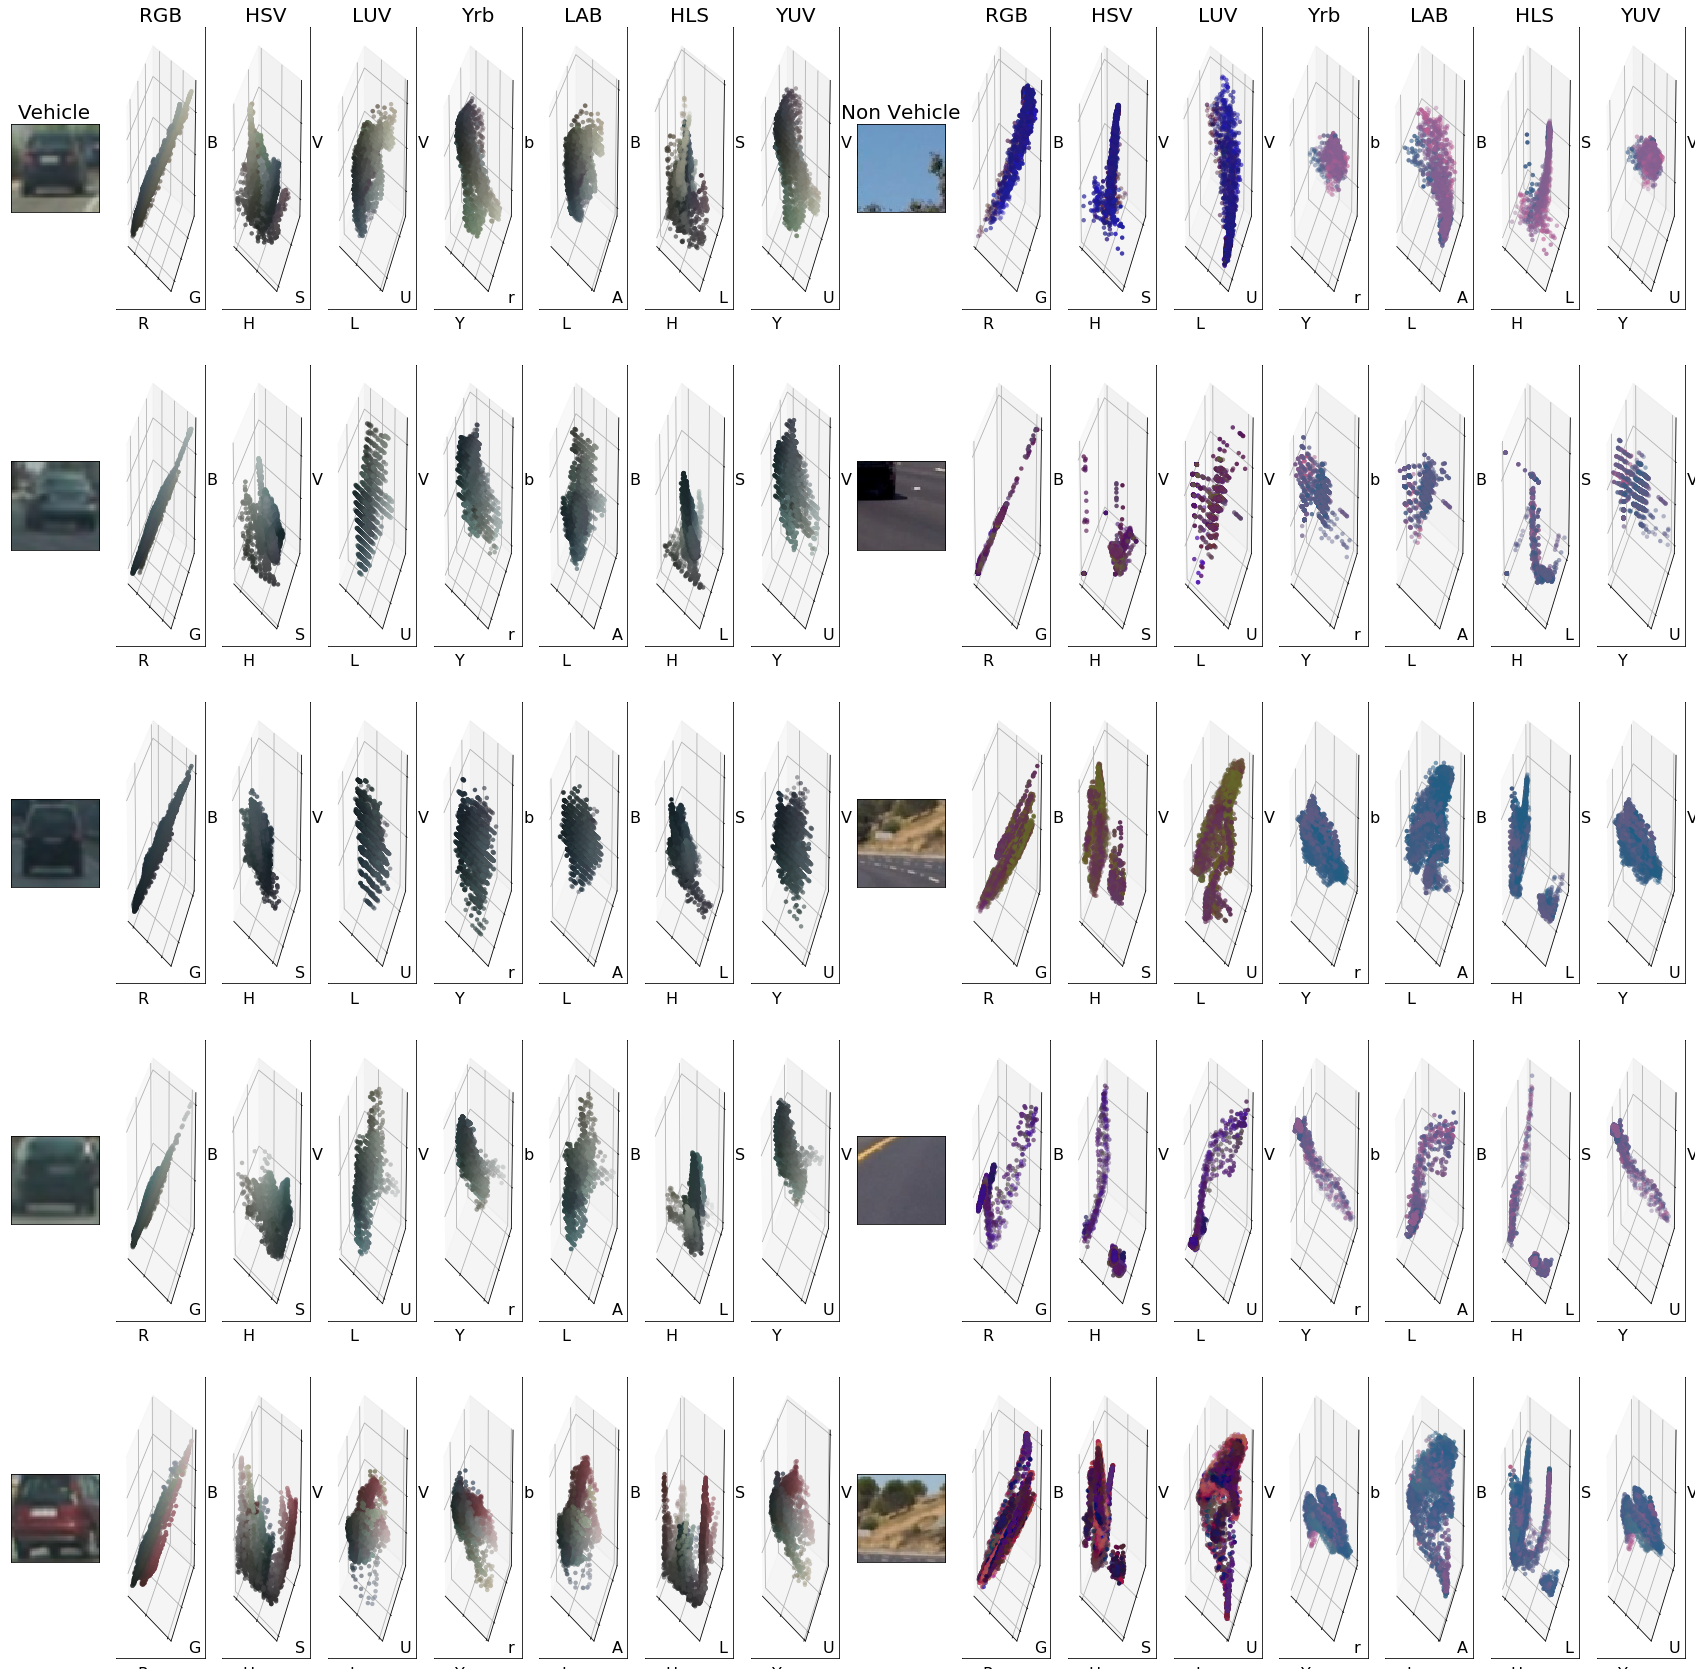

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb ,ax, axis_labels=list("RGB")):
        
    # Set axis labels and sizes
    ax.tick_params(which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    ax.set_xlabel(axis_labels[0], fontsize=16)
    ax.set_ylabel(axis_labels[1], fontsize=16)
    ax.set_zlabel(axis_labels[2], fontsize=16)
    # Plot pixel values with colors given in colors_rgb
    
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

def visualize_3d(preview_images):
    image_grid = []
    num_color_spaces = 7

    for i in range(len(preview_images)):
        image_grid.append(preview_images[i])
        img_data = [[] for j in range(num_color_spaces)]
        for k in range(len(preview_images[i])):
            img_data[0].append(np.array(preview_images[i][k]))
            img_data[1].append(np.array(cv2.cvtColor(preview_images[i][k],cv2.COLOR_RGB2HSV)))
            img_data[2].append(np.array(cv2.cvtColor(preview_images[i][k],cv2.COLOR_RGB2LUV)))
            img_data[3].append(np.array(cv2.cvtColor(preview_images[i][k],cv2.COLOR_RGB2YCrCb)))
            img_data[4].append(np.array(cv2.cvtColor(preview_images[i][k],cv2.COLOR_RGB2LAB)))
            img_data[5].append(np.array(cv2.cvtColor(preview_images[i][k],cv2.COLOR_RGB2HLS)))
            img_data[6].append(np.array(cv2.cvtColor(preview_images[i][k],cv2.COLOR_RGB2YUV)))
            
        for j in range(num_color_spaces):
            image_grid.append(img_data[j])
        
    titles = ['Vehicle','RGB','HSV','LUV','Yrb','LAB','HLS','YUV','Non Vehicle','RGB','HSV','LUV','Yrb','LAB','HLS','YUV']
    col_type = ['img','3d','3d','3d','3d','3d','3d','3d','img','3d','3d','3d','3d','3d','3d','3d']
    grid_plot(image_grid,titles,col_type,figsize = (30,30))
# Read a color image

visualize_3d(preview_images)

## Spatial Binning of Color (Resizing)

The last idea is to just give the model the image. Alhough a full resolution image would have too much data for the model to learn, therefore making it harder for the model to generalize, a scaled down image could certianlly help. As seen below it looks like 32x32 doesn't lose much data, 16x16 is enough but it starts to get blurry, and 8x8 isn't enough 

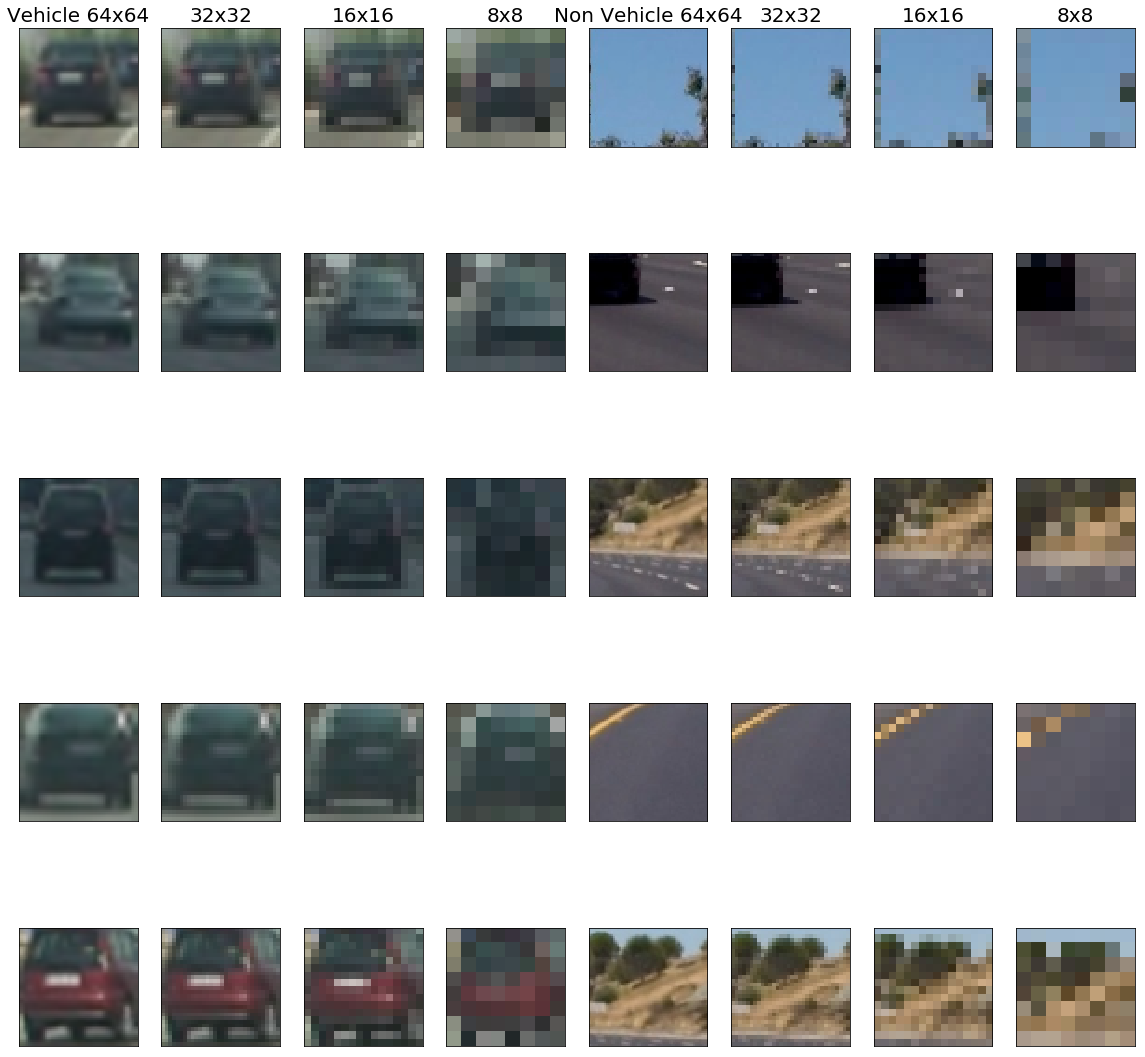

In [7]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, size=(16, 16) , ravel = True, interpolation = cv2.INTER_NEAREST):
    features = cv2.resize(img, size,interpolation = interpolation)
    
    if ravel:
        features = features.ravel()
        
    return features


def visualize_bin(preview_images):
    image_grid = []
    num_sizes = 3
    for row in preview_images:
        image_grid.append(row)
        size_data = [[] for i in range(num_sizes)]
        for img in row:
            size_data[0].append(bin_spatial(img,size = (32,32),ravel = False))
            size_data[1].append(bin_spatial(img,size = (16,16),ravel = False))
            size_data[2].append(bin_spatial(img,size = (8,8), ravel = False))
            
        for i in range(num_sizes):
            image_grid.append(size_data[i])
    titles = ['Vehicle 64x64','32x32','16x16','8x8','Non Vehicle 64x64','32x32','16x16','8x8']
    
    grid_plot(image_grid,titles,figsize = (20,20))
    

visualize_bin(preview_images)

## Comparing Interpolation Algorithms

I want to run my model with the fewest parameters possible, so I want the sharpest low res image. After comparing the interpolation algorithms two things are clear. First that all of the interpolation algorithms except 'nearest' are nearly identical, and that it was very clear that all the non vehicle images did not contain vehicles. 

Even though 'nearest' doesn't do the best job of downsizing, it's gets the job done and it's the fastest, so that's what I will be using.

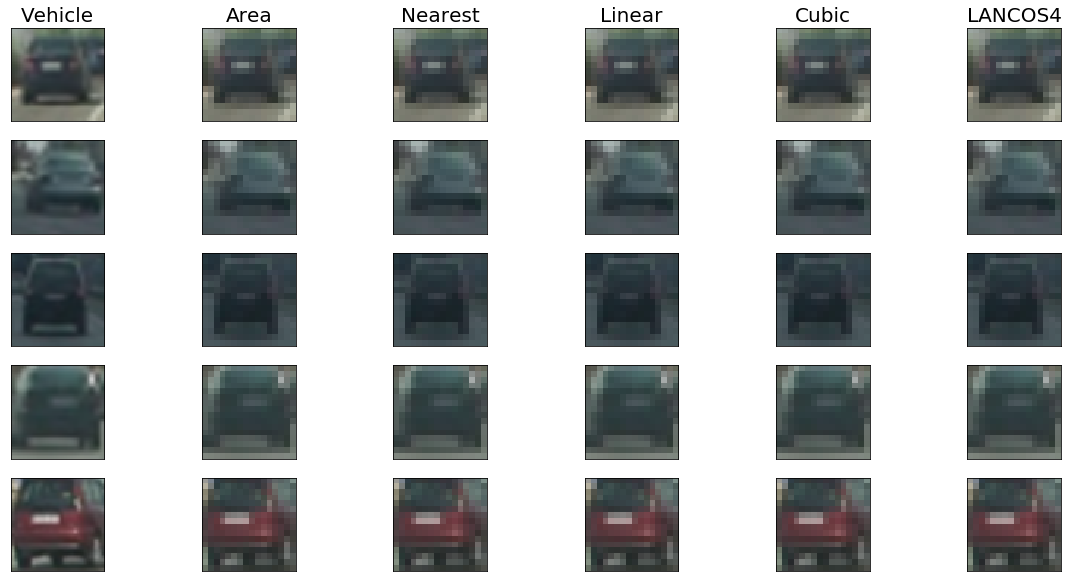

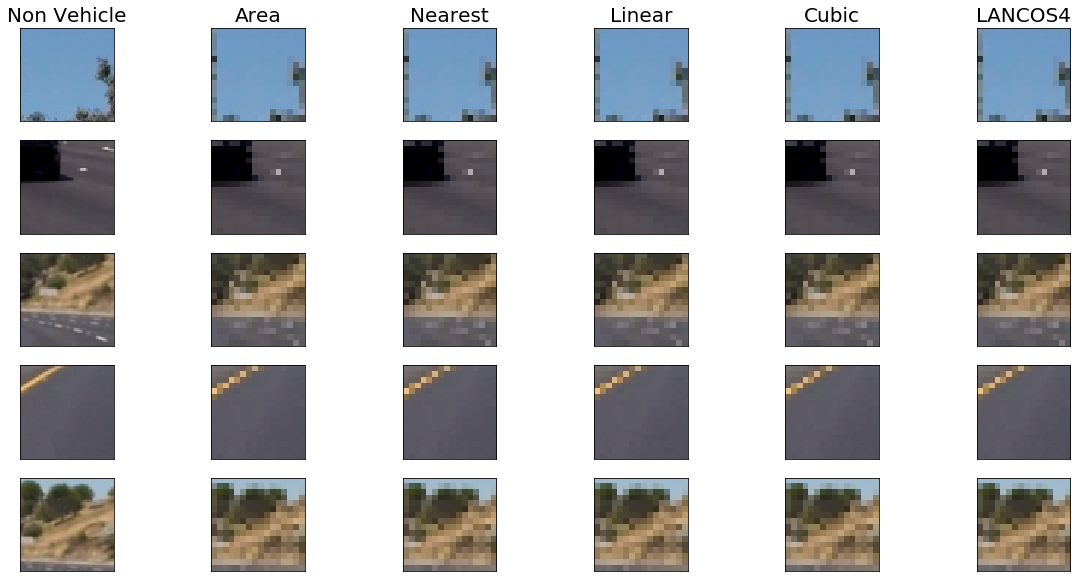

In [8]:
def visualize_interpolation(preview_images):
    num_sizes = 5
    for i in range(len(preview_images)):
        image_grid = []
        image_grid.append(preview_images[i])
        size_data = [[] for j in range(num_sizes)]
        for img in preview_images[i]:
            size_data[0].append(bin_spatial(img,size = (16,16),ravel = False, interpolation = cv2.INTER_AREA ))
            size_data[1].append(bin_spatial(img,size = (16,16),ravel = False, interpolation = cv2.INTER_NEAREST))
            size_data[2].append(bin_spatial(img,size = (16,16),ravel = False, interpolation = cv2.INTER_LINEAR))
            size_data[3].append(bin_spatial(img,size = (16,16),ravel = False, interpolation = cv2.INTER_CUBIC))
            size_data[4].append(bin_spatial(img,size = (16,16),ravel = False, interpolation = cv2.INTER_LANCZOS4))
            

        for j in range(num_sizes):
            image_grid.append(size_data[i])
            
        titles = [i*'Non '+'Vehicle','Area','Nearest','Linear','Cubic','LANCOS4']#,'Non Veh','Area','Nearest','Linear','Cubic','LANCOS4']

        grid_plot(image_grid,titles,figsize = (20,10))
    

visualize_interpolation(preview_images)

## Training an SVM & Helper Functions

As it turns out, many of Udacity's partners use older machine learning algorithms in their self driving car pipelines. My understanding is that my goal should be to get experience with SVM's and more importantly understand their limitations. From here I normalize and unroll all of the features.

In [142]:
# Returns equally spaced bins over each channel of and image
def hist_bins(cspace = 'RGB', bins = 32):
    crange = color_range(cspace)
    return [np.linspace(crange[i][0],crange[i][1],bins) for i in range(3)]

# Returns the range of each channel of a color space
def color_range(cspace = 'RGB'):
    
    if cspace == 'HLS' or cspace == 'HLS':
        cspace_range = [[0,180],[0,255],[0,255]]
    else:
        cspace_range = [[0,255],[0,255],[0,255]]
        
    return cspace_range

# Returns a histogram of color given an image and bins
def color_hist_bins(img, bins):
    # Compute the histogram of the RGB channels separately
    
    hist = []
    for i in range(3):  
        hist.append(np.histogram(img[:,:,i], bins=bins[i]))

    return hist

# Takes an RGB image and returns an image in a different color space
def change_color_space(image,cspace = 'RGB'):
    if cspace == 'RGB':
        feature_image = np.array(image)
    elif cspace == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    elif cspace == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        
    elif cspace == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    elif cspace == 'LAB':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        
    elif cspace == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    elif cspace == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        
    return feature_image

# Normalizes an image over each color channel 
def normalize_image(image,cspace = 'RGB', copy = False):
    
    image = np.array(image).astype(float)
    crange = color_range(cspace)
    #Min Max Normalzation
    for i in range(3):
        image[:,:,i] = (image[:,:,i]-crange[i][0])/(crange[i][1]/2)-1
        
    return image

# Extracts HOG,HOC,and Spatial data from an image
def extract_data(image,cspace = 'RGB',bins = 32,size = (16,16)):
    
    #Convert Color
    feature_image = change_color_space(image,cspace)
    
    #Load gradient
    gradient = [get_hog_features(feature_image[:,:,i],feature_vec = False) for i in range(3)]
    gradient = np.vstack(gradient).ravel()
    
    #Load color
    color = color_hist_bins(feature_image,hist_bins(cspace,bins))
    color = np.vstack(np.array(color)[:,0]).ravel()
    
    #Load Spatial
    spatial = bin_spatial(feature_image, size = size ,ravel=False)
    spatial = normalize_image(spatial, cspace, copy = False)
    spatial = spatial.ravel()
    
    return gradient, color, spatial

# Loads All Images
def prepare_images(imgs, cspace='RGB',bins=32,spatial_size = (16,16),gradient_scaler = None, color_scaler = None, verbose = False):
    if verbose:
        print("Extracting Features For ",len(imgs)," Images")
    num_features = 3
    features = [[] for i in range(num_features)]    
    for file in imgs:
        
        data = extract_data(mpimg.imread(file),cspace = cspace, bins = bins,size = spatial_size)
        
        for i in range(num_features):
            features[i].append(data[i])
        
        if verbose and len(features[0])%100 == 0:
            print(len(features[0]), "Images Extracted")
            
    if gradient_scaler is None:
         gradient_scaler = StandardScaler().fit(np.vstack(features[0]))
    
    if color_scaler is None:
        color_scaler = StandardScaler().fit(np.vstack(features[1]))
    
    features[0] = gradient_scaler.transform(features[0])
    features[1] = color_scaler.transform(features[1])
    
    output = []
    for i in range(len(features[0])):
        output.append(np.concatenate([features[j][i] for j in range(num_features)]))

            
    return output,gradient_scaler,color_scaler

cspace RGB
(0, 0, 2, 2, 9)
(0,)
(0,)
(93,)
(768,)


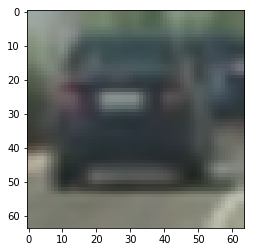

In [124]:
plt.imshow(preview_images[0][0])

data= extract_data(cv2.resize(preview_images[0][0],(8,8)))

for i in range(3):
    print(data[i].shape)

In [21]:
print("woo")

woo


## Searching for Optimal Color Space 

Earlier I plotted some images in 3D to get a grasp of how different color spaces can give more information when trying to detect a vehicle. After plotting the images I had a rough idea that RGB wasn't the best color space, but not much beyond a gut feeling about which ones would work. Below I tested the different color spaces on the entire dataset to get a more quantative understanding of what color space works the best. HSV and HLS preformed the best with RGB coming in last place.  

In [26]:
def lin_search_color_spaces(all_files,y,color_spaces,num_train):
    for color_space in color_spaces:
        
        if num_train == "ALL":
            test_files = all_files
            y = y
        else:
            #take first and last n/2 elements since they're loaded as [1,1,1,...,0,0,0]
            test_files = all_files[0:num_train//2]+all_files[-1:-num_train//2-1:-1]
            y =  y[0:num_train//2] + y[-1:-num_train//2-1:-1]        
        features,_,_ = prepare_images(test_files,cspace = color_space,spatial_size = (32,32))
        clf = svm.SVC(kernel='linear', C=1)
        scores = cross_val_score(clf, features, y, cv=5)
        
        print('Test Accuracy of', color_space, 'SVC = ', sum(scores)/float(len(scores)))
    
    
    
color_spaces = ['RGB','HSV','LUV','YCrCb','LAB','HLS','YUV']
all_files = files[0] + files[1]
lin_search_color_spaces(all_files,y,color_spaces,"ALL")



Test Accuracy of RGB SVC =  0.938012633614
Test Accuracy of HSV SVC =  0.965653974967
Test Accuracy of LUV SVC =  0.952703491849
Test Accuracy of YCrCb SVC =  0.949887193495
Test Accuracy of LAB SVC =  0.951182444701
Test Accuracy of HLS SVC =  0.96525962468
Test Accuracy of YUV SVC =  0.949268474


## Searching For Optimal Spatial Size

Earlier I made the assumption that using a spatial size of (32,32) didn't lose too much data, and while (16,16) was lossy, it still had enough data to help make decisions. Below I tested equally spaced spatial sizes. Note that I am not doing a grid search of color spaces and spatial sizes because I don't believe they are heavily corelated. Although, it is possible that one of the color spaces works much when downsized. That said, I found that for HSV the resolution of the image didn't have much effect on the output. This implies that the actual image isn't useful, or isn't as useful as the other features. 

That said 64x64 did give my model a bit of an edge over the 8x8 version. I'm worried that including it could cause overfitting, but I'll have to wait until I'm working with the video to see if it hurst more than it helps. 

In [27]:
def log_search_spatial_sizes(all_files,y,spatial_sizes,num_train):
    for size in spatial_sizes:
        if num_train == "ALL":
            test_files = all_files
            y = y
        else:
            #take first and last n/2 elements since they're loaded as [1,1,1,...,0,0,0]
            test_files = all_files[0:num_train//2]+all_files[-1:-num_train//2-1:-1]
            y =  y[0:num_train//2] + y[-1:-num_train//2-1:-1]
            
        features,_,_ = prepare_images(test_files, cspace = 'HSV',spatial_size = size)
        
        clf = svm.SVC(kernel='linear', C=1)
        scores = cross_val_score(clf, features, y, cv=5)
    
        print('Test Accuracy of', size , 'SVC = ', sum(scores)/float(len(scores)))
    
    
spatial_sizes = [(64,64),(48,48),(32,32),(24,24),(16,16),(12,12),(8,8)]
all_files = files[0] + files[1]
log_search_spatial_sizes(all_files,y,spatial_sizes,'ALL')

Test Accuracy of (64, 64) SVC =  0.966949004254
Test Accuracy of (48, 48) SVC =  0.966329603136
Test Accuracy of (32, 32) SVC =  0.965653974967
Test Accuracy of (24, 24) SVC =  0.965372538521
Test Accuracy of (16, 16) SVC =  0.965428543652
Test Accuracy of (12, 12) SVC =  0.964302512549
Test Accuracy of (8, 8) SVC =  0.962556858391


## Train Best Model

In [28]:
def train_model(all_files, y,cspace = 'HSV',spatial_size = (64,64)):
    
    features,gradient_scaler,color_scaler = prepare_images(all_files, cspace ,spatial_size = spatial_size)

    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(features,y)
    
    return clf,gradient_scaler,color_scaler

def cross_validation_test_model(all_files,y,cspace = 'HSV',spatial_size = (48,48)):
    
    features,_,_ = prepare_images(all_files, cspace ,spatial_size = spatial_size)

    clf = svm.SVC(kernel='linear', C=1)
    scores = cross_val_score(clf, features, y, cv=5)
    
    print('Test Accuracy of',cspace,spatial_size,'model =', sum(scores)/float(len(scores)))

In [29]:
model, gradient_scaler, color_scaler = train_model(np.concatenate(files),y)
print("Done")

Done


In [30]:
import pickle
trained_model = {model,gradient_scaler,color_scaler}
pickle.dump({model,gradient_scaler,color_scaler} , open( "model.p", "wb" ))

In [31]:
model, gradient_scaler, color_scaler = pickle.load( open("model.p", "rb" ) )

In [84]:

tm = list(trained_model)
for element in tm:
    print(type(element))

<class 'sklearn.preprocessing.data.StandardScaler'>
<class 'sklearn.svm.classes.SVC'>
<class 'sklearn.preprocessing.data.StandardScaler'>


## Crop Images And Run HOG

Before I pass my images to be processed, I want remove all the irrelevant pixels. Also I have overlapping search windows and I don't want to run HOG multiple times on the same pixels. To get around this, I run HOG on the entire cropped image once. Later I will subsample from that image. Note that while the images shown are loaded and processed in RGB format, for the actual video they will be converted to the HSV color space.

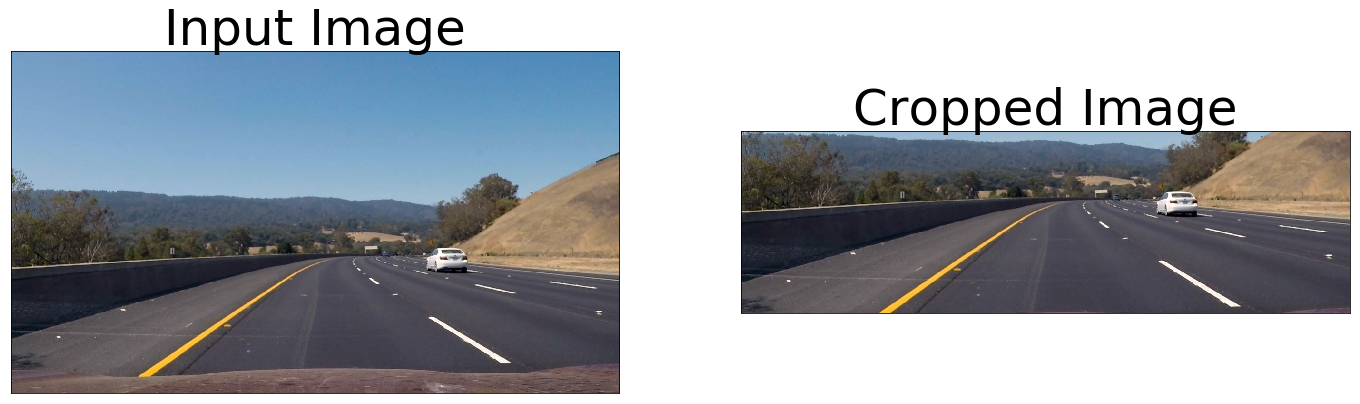

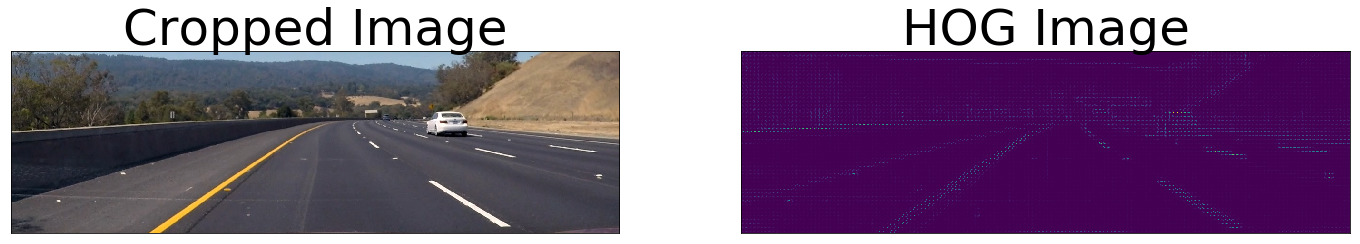

(47, 159, 2, 2, 9)


In [61]:
def vertical_crop(img,ymin = 286,ymax = 670):
    return img[ymin:ymax,:]
    
def show_crop_hog(img):
    
    crop = vertical_crop(img[:,:,:])
    _,hog = get_hog_features(crop[:,:,0], vis = True)
    plot_two_images(img,crop,"Input Image","Cropped Image")
    plot_two_images(crop,hog,"Cropped Image","HOG Image")
    
example_image = mpimg.imread("test_images/test3.jpg")
show_crop_hog(example_image[:,:,:])
   

orient = 9
pix_per_cell = 8
cell_per_block = 2  

crop_hog = [get_hog_features(vertical_crop(example_image[:,:,i]),
                             orient = orient, pix_per_cell = pix_per_cell, 
                             cell_per_block = cell_per_block, feature_vec = False) 
            for i in range(3)]

## Scale Size Restricted Search 

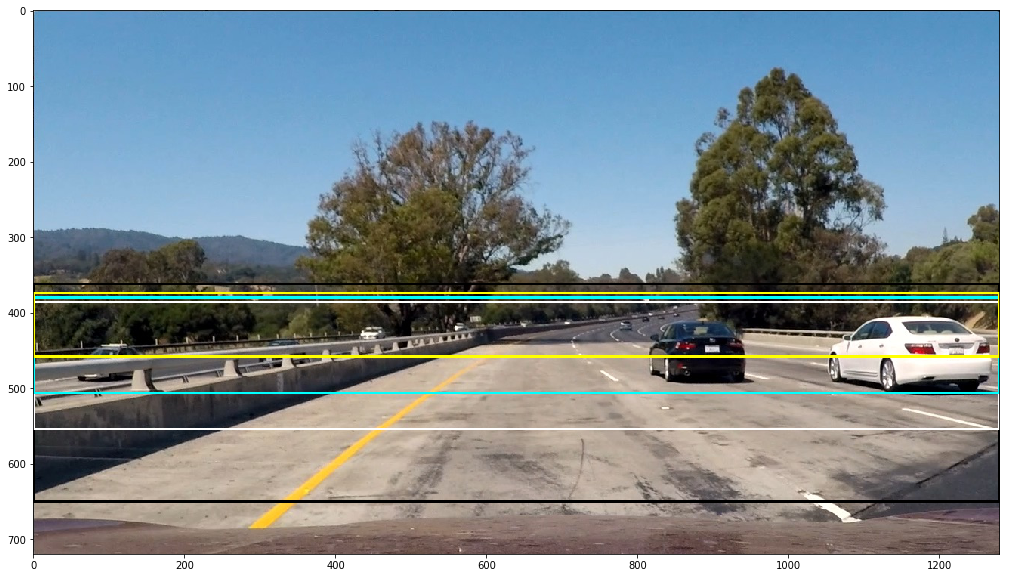

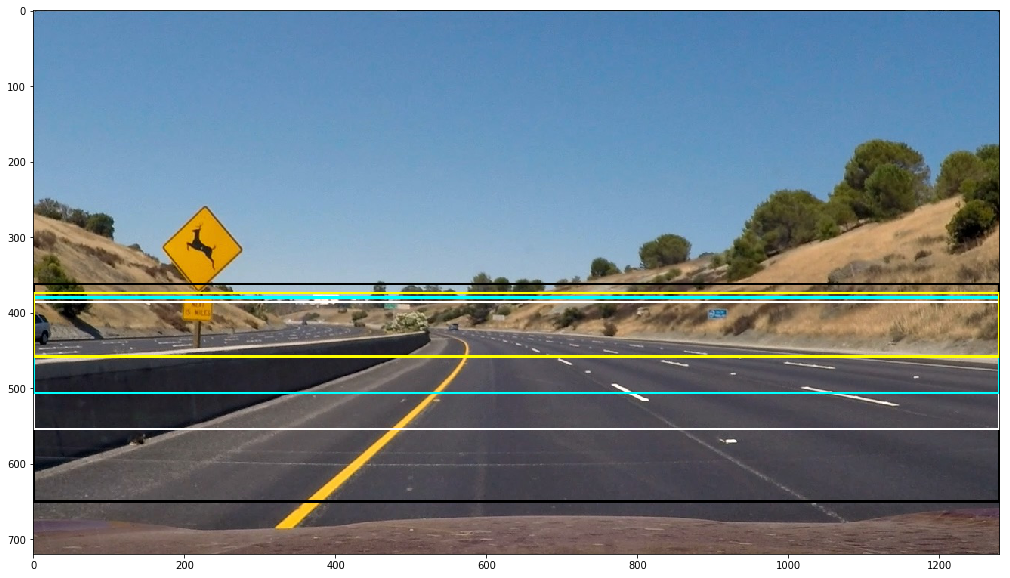

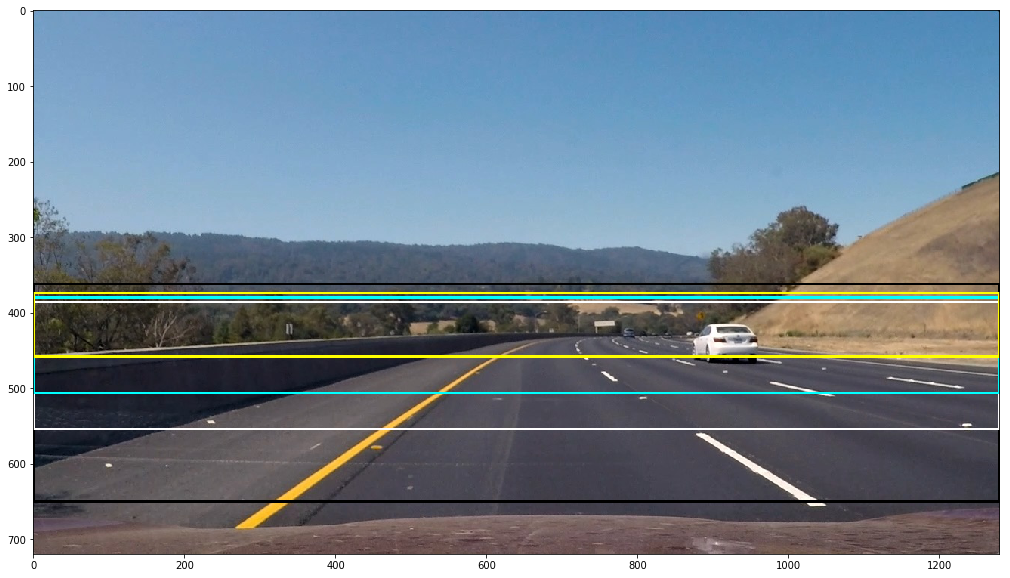

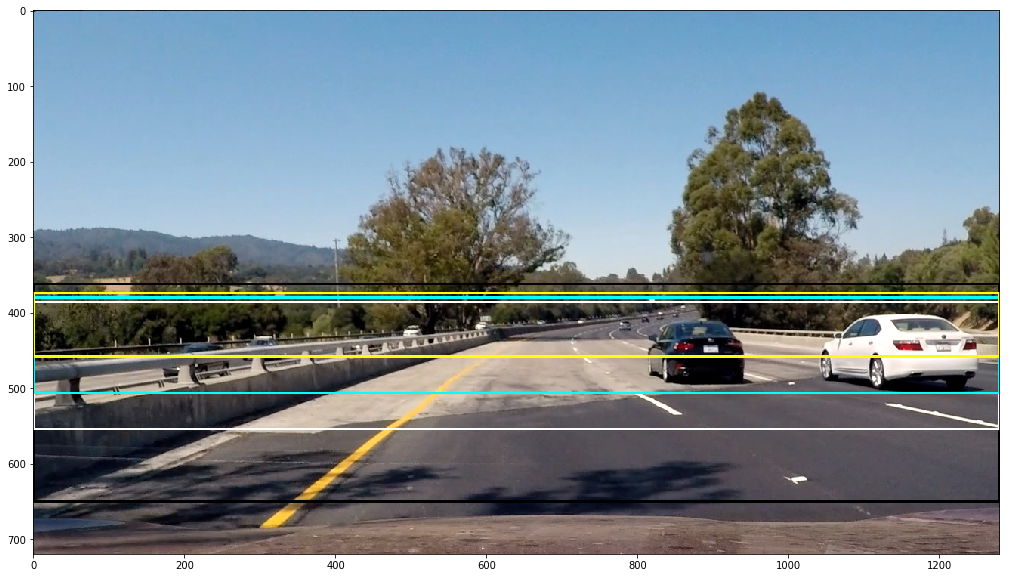

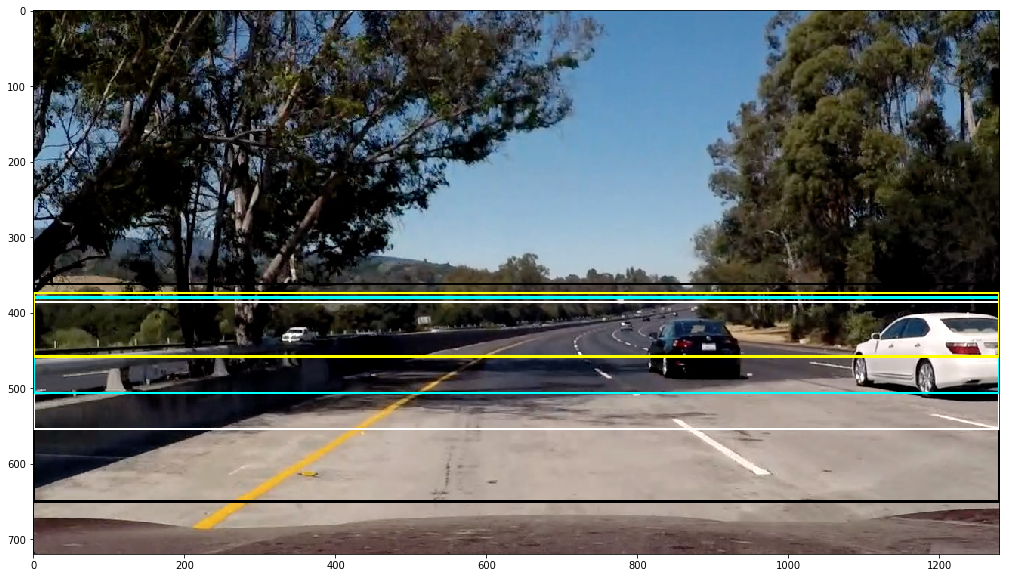

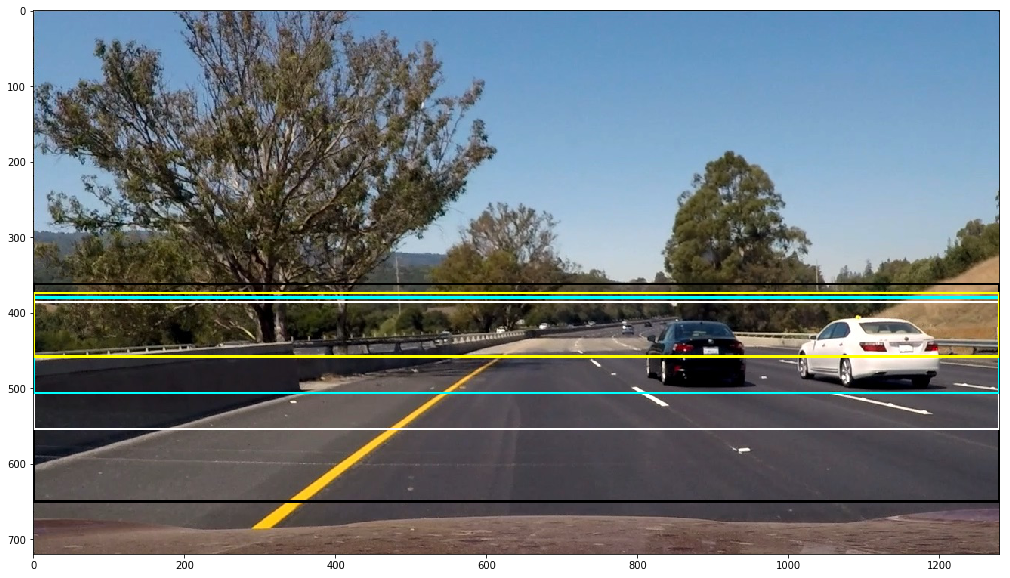

In [319]:

def get_scale_crop(scales):
    scale_crop = []
    x = [0,1279]
    basey = 650
    for i in range(len(scales)):
        height = int(scales[i]*1.5)
        if i == 0:
            scale_crop.append([x,[basey-height,basey]])
        else:
            #Hi Refers to pixel number, aka the bottom line
            hi = int(basey-scales[0]*1.5+height*.125)
            lo = int(hi+height*.875)
            scale_crop.append([x,[hi,lo]])
    return scale_crop


def visualize_scale_crop(scales):
    scale_crop = get_scale_crop(scales)
    test_images = []

    #Load Test Images
    for i in range(1,7):
        test_images.append(mpimg.imread("test_images/test"+str(i)+".jpg"))

    #Draw Boxes on Images and Plot
    for img in test_images:
        for crp,clr in zip(scale_crop,colors):
            cv2.rectangle(img,(crp[0][0],crp[1][0]),(crp[0][1],crp[1][1]),clr,2)
        plt.figure(figsize=(20,10))
        plt.imshow(img)
        plt.show()


scales = [192,128,96,64]
visualize_scale_crop(scales)
        


## Image Scanning Pipeline

Now that I have a model, I need to scan an image where I expect cars to be to try to detect them.

## Scanning Helper Functions

Vehicles get smaller the farther away they are from the camera. On a flat plane, aka a road, cars will get smaller the closer they get to the horizon, so it doesn't make sense to search at the bottom of the image for the smallest cars. Using this logic, I can search from about the middle to about the bottom of the image for the largest cars, then incrementally step down to the smallest size near the center of the image.

In [373]:
def get_scaled_images(img, scales):#, xbounds, ybounds):
    images = []
    shape = img.shape
    for scale in scales:
        if scale == 1:
            images.append(img)
        else:
            images.append(cv2.resize(img,(shape[1]/scale,shape[0]/scale)))
            
    return images

def extract_color_data(imagecspace = 'RGB',bins = 32,size = (16,16)):
    
    #Convert Color
    feature_image = change_color_space(image,cspace)
    
    #Load gradient
    gradient = [get_hog_features(feature_image[:,:,i]) for i in range(3)]
    gradient = np.vstack(gradient).ravel()
    
    #Load color
    color = color_hist_bins(feature_image,hist_bins(cspace,bins))
    color = np.vstack(np.array(color)[:,0]).ravel()
    
    #Load Spatial
    spatial = bin_spatial(feature_image, size = size ,ravel=False)
    spatial = normalize_image(spatial, cspace, copy = False)
    spatial = spatial.ravel()
    
    return gradient, color, spatial

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_cars(img,scales,scale_crop,svc,gradient_scaler,color_scaler,orient,pix_per_cell,cell_per_block,spatial_size,bins,show_all_boxes = False):
    
    draw_img = np.copy(img)
    hsv = change_color_space(img,cspace = 'HSV')
        
    if heatmap:
        heatmap.add_frame()
        heat_box = []
    for scale,crop in zip(scales,scale_crop):
        #print(crop)
        cropped = hsv[crop[1][0]:crop[1][1],crop[0][0]:crop[0][1],:]
        shape = cropped.shape
        #print(shape)
        #print(shape,(crop[1][1]-crop[1][0])/scale,(crop[0][1]-crop[0][0])/scale)
        scaled = cv2.resize(cropped,(int((crop[0][1]-crop[0][0])/scale),96))
        #plt.imshow(cv2.cvtColor(scaled,cv2.COLOR_HSV2RGB))
        #plt.show()
        new_shape = scaled.shape
        
        #print(new_shape)
        hogs = [get_hog_features(scaled[:,:,i],feature_vec = False) for i in range(3)]
        
        nxblocks = (new_shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (new_shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2
        
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 3  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
        #print(nxsteps,nysteps,nxblocks,nyblocks,nblocks_per_window)
        for xb in range(nxsteps+1):
            for yb in range(nysteps+1):
                
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                sub_hogs = [hogs[i][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window] for i in range(3)]
                
                hog_features = np.vstack(sub_hogs).ravel()
                hog_features = gradient_scaler.transform(hog_features)
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = scaled[ytop:ytop+window, xleft:xleft+window]
                #plt.imshow(cv2.cvtColor(subimg,cv2.COLOR_HSV2RGB))
                #plt.show()
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size,ravel = False)
                spatial_features = normalize_image(spatial_features, 'HSV', copy = False).ravel()
                
                hist_features = color_hist_bins(subimg,hist_bins('HSV',bins))
                hist_features = np.vstack(np.array(hist_features)[:,0]).ravel()
                hist_features = color_scaler.transform(hist_features)
                
                test_features = np.concatenate((hog_features,hist_features,spatial_features))
                # Scale features and make a prediction
                test_prediction = svc.predict(test_features)
                
                if test_prediction == 1 or show_all_boxes:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    if heatmap:
                        heat_box.append([(xbox_left, ytop_draw+crop[1][0]),(xbox_left+win_draw,ytop_draw+win_draw+crop[1][0])])
                        
                    else:
                        cv2.rectangle(draw_img,(xbox_left, ytop_draw+crop[1][0]),(xbox_left+win_draw,ytop_draw+win_draw+crop[1][0]),(255,255,255),6)
                    
        
    if heatmap:
        heatmap.add_heat(heat_box)
        thresh_heat = heatmap.get_combined_image()
        #plt.imshow(thresh_heat,cmap = 'gray')
        #plt.show()
        labels = label(thresh_heat)
        #plt.imshow(labels[0],cmap = 'gray')
        #plt.show()
        draw_img = draw_labeled_bboxes(draw_img,labels)
        #plt.imshow(draw_img)
        #plt.show()
    return draw_img


In [ ]:
def visualize_find_cars(scales):
    ratio_scales = [scale/64 for scale in scales]
    window_size = 64

    test_images = []
    
    ret_images = [[],[]]
    for i in range(1,7):
        test_images.append(mpimg.imread("test_images/test"+str(i)+".jpg"))

    for img in test_images:
        ret_images[0].append(find_cars(img,ratio_scales,scale_crop,tm[1],tm[0],tm[2],9,8,2,(64,64),32,show_all_boxes = True))
        ret_images[1].append(find_cars(img,ratio_scales,scale_crop,tm[1],tm[0],tm[2],9,8,2,(64,64),32,show_all_boxes = False))
        
    grid_plot(ret_images,['Search Space','Found Cars'],figsize = (20,20))

visualize_find_cars(scales)


In [382]:
class Heatmap():
    def __init__(self):
        self.n = 15
        self.threshold = 4
        self.heat_queue = deque()
        self.combined_image = np.zeros([720,1280])
        self.cur_frame = None
        
    def add_frame(self):
        if len(self.heat_queue) == self.n:
            self.pop_frame()
            
        self.cur_frame = np.zeros([720,1280])
        self.heat_queue.append(self.cur_frame)
            
    def pop_frame(self):
        self.combined_image -= self.heat_queue.popleft()
        
    def get_combined_image(self):
        self.update_combined_image()
        out = np.copy(self.combined_image)
        out[out <= self.threshold] = 0

        return out
        
    def update_combined_image(self):
        self.combined_image += self.cur_frame
        
    def add_heat(self,bbox_list):
        for box in bbox_list:
            self.cur_frame[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

In [383]:
window_size = 64
scales = [192,128,96,64]
ratio_scales = [scale/64 for scale in scales]
scale_crop = get_scale_crop(scales)
model, gradient_scaler, color_scaler = tm[1],tm[0],tm[2]
orient , pix_per_cell, cell_per_block = 9,8,2
spatial_size = (64,64)
bins = 32
heatmap = Heatmap()
def process_image(img):
    return find_cars(img,ratio_scales,scale_crop,model,
                     gradient_scaler,color_scaler,orient,
                     pix_per_cell,cell_per_block,spatial_size,
                     bins,show_all_boxes = False)
    
    

In [384]:

clip = VideoFileClip("project_video.mp4")
new_clip = clip.fl_image(process_image)
%time new_clip.write_videofile("output_proejct_video.mp4", audio = False)

[MoviePy] >>>> Building video output_proejct_video.mp4
[MoviePy] Writing video output_proejct_video.mp4



100%|█████████▉| 1260/1261 [3:48:24<00:07,  7.62s/it]    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_proejct_video.mp4 

CPU times: user 2h 44min 6s, sys: 1min 2s, total: 2h 45min 9s
Wall time: 3h 48min 26s
